# Configuración en Google Drive
- Ejecutar las siguientes celdas si se trabajará con el presente Jupyter Notebook en Google Drive.
- En caso de ejecutarlo en una PC local, omitir estas celdas.
- Clonar el repositorio de GitHub en su computadora local.
- Subir a Google Drive el directorio "project" que se encuentra en la carpeta "ceia_uba/part_2".

De esta manera, toda ejecución en el Jupyter Notebook que produzca archivos de salida serán almacenados en las carpetas internas del proyecto de forma consistente.

### Instrucciones

1) Instalar paquetes necesarios a través de pip.
2) Importar paquetes necesarios.
3) Montar Google Drive.
4) Definir rutas dentro del proyecto.
5) Importar paquetes propios.

In [ ]:
%%capture
!pip install numpy scipy matplotlib pandas
!pip install torch torchvision torchaudio torchsummary
!pip install pytorch-lightning
!pip install opencv-python
!pip install albumentations

In [1]:
import sys
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2

import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
ROOT_PATH = "/content/drive/MyDrive/project/"
TRAIN_PATH = ROOT_PATH + "dataset/train/"
VALID_PATH = ROOT_PATH + "dataset/valid/"
TEST_PATH = ROOT_PATH + "dataset/test/"
FIGURES_PATH = ROOT_PATH + "figures/"
MODELS_PATH = ROOT_PATH + "models/"
METRICS_PATH = ROOT_PATH + "metrics/"
SOURCE_PATH = ROOT_PATH + "src/"

In [ ]:
sys.path.append(SOURCE_PATH)
from src.dataset import *
from src.cnn import *
from src.encoder import *

# Configuración en PC local
- Ejecutar las siguientes celdas si se trabajará con el presente Jupyter Notebook en una PC local.
- En caso de ejecutarlo en Google Drive, omitir estas celdas.
- Clonar el repositorio de GitHub en su computadora local.
- Abrir el proyecto con su entorno de desarrollo (e.g. VSCode).

De esta manera, toda ejecución en el Jupyter Notebook que produzca archivos de salida serán almacenados en las carpetas internas del proyecto de forma consistente, dentro de la carpeta "project", localmente.

### Instrucciones

1) Instalar paquetes necesarios a través de pip (ejecutar las intrucciones para crear el entorno virtual). Los paquetes necesarios se encuentran en el archivo *requirements.txt*. Las intrucciones se encuentran en el archivo *README.md*.
2) Importar paquetes necesarios.
3) Importar paquetes propios.
4) Definir rutas dentro del proyecto.

In [1]:
import matplotlib.pyplot as plt

from src.dataset import *
from src.cnn import *
from src.encoder import *

/Users/aperezwinter/Desktop/ceia/computerVision/venv/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
ROOT_PATH = os.getcwd()
TRAIN_PATH = ROOT_PATH + "/dataset/train/"
VALID_PATH = ROOT_PATH + "/dataset/valid/"
TEST_PATH = ROOT_PATH + "/dataset/test/"
FIGURES_PATH = ROOT_PATH + "/figures/"
MODELS_PATH = ROOT_PATH + "/models/"
METRICS_PATH = ROOT_PATH + "/metrics/"
SOURCE_PATH = ROOT_PATH + "/src/"

### Establecer el dispositivo

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Usando MPS (Apple GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Usando CUDA (NVIDIA GPU)")
else:
    device = torch.device("cpu")
    print("Usando CPU")

Usando MPS (Apple GPU)


# Modelo Base
El modelo base consiste en una red neuronal con cuatro capas convolucionales, seguido de una capa *fully connected*.

Para cada bloque convolucional se puede establecer (por el usuario):
- Canales de entrada.
- Canales de salida.
- Tamaño del kernel, stride y padding.
- Modo del padding, i.e. como completar los píxeles extras.
- Función de activación.
- Tamaño del kernel, stride y padding en la capa de Max Pooling.

Para la clase de la red neuronal convolucional se peude establecer (por el usuario):
- La forma de la imagen de entrada (C, H, W), donde C es el número de canales, H es la altura y W es el ancho, en píxeles para estos últimos dos.
- El número de clases a clasificar.
- El número de neuronas a la salida de la capa *fully connected*.
- La función costo.
- La tasa de *dropout*.
- El tipo de inicialización de los pesos en la red.
- El dispositivo a utilizar, e.g. *cpu*, *gpu*, etc.

## Variantes
El Dataset elegido consiste en cartas de Poker. Contiene un total de 53 clases, con 7624 imágenes de entrenamiento, 265 de validación y 265 de prueba. Todas las imágenes son en color (RGB, 3 canales) y su dimensión es de 224 x 224 píxeles.

### Data Augmentation
Si bien el dataset tiene imágenes diversas dentro de cada clase, aproximadamente se tiene 144 imágenes por cada clase. Resulta en una aproximación pues la distribución no es exactamente uniforme. Luego de explorar visualmente el dataset, se observa que la mayoría de las cartas son monocromáticas, es decir, de un solo color. Por ejemplo, hay cartas solo de color rojo o negro, con fondo blanco. Las variaciones que se observan son, entre otras: giros, recortes, cambios de perspectiva, simbología extra, temáticas, etc. Sin embargo, se propone aumentar el dataset medianta *data augmentation*. Las transformaciones a realizar son:
- Desplazamiento, escalado y rotación. Las regiones vacías se rellenan con el color negro y los giros oscilan entre +/- 15 grados.
- Variación aleatoria en el brillo y contraste.
- Volteo horizontal.

El proceso de *data augmentation* se peude realizar la cantidad de veces que uno desea. Por ejemplo, al realizar este proceso una sola vez, el dataset se duplica. La transformación se aplica a cada imagen del dataset. Por lo tanto si aplico N veces el proceso obtengo N + 1 veces imágenes en total.

### Blanco y Negro
Dado que las imágenes son a color (RGB), se propone la alternativa de trabajar en blanco y negro, i.e. reducir el número de canales de 3 a 1. De esta forma, se reduce la infromación a un tercio, lo cual lo hace bastante atractivo computacionalmente. Además, esta desición se basa en la hipótesis de que detectar a que clase pertenece cada carta no depende del color en sí, sino de la froma del número o símbolo. En la misma línea, la simbología casi en todos los casos está pintada de un solo color, por lo que podemos pensar que el color en sí no es una variable predominante en la clasificación. Por ende, está hipótesis será puesta a prueba en la resolución.

# Resolución: Color & Data Augmentation

#### Definición de parámetros principales

In [4]:
params_rgb_dag = {
        'conv_layers': [
            {
                'in_channels': 3,
                'out_channels': 16,
                'kernel_size': 3,
                'stride': 1,
                'padding': 1,
                'padding_mode': 'zeros',
                'pool_kernel_size': 2,
                'pool_stride': 2,
                'pool_padding': 0
            },
            {
                'in_channels': 16,
                'out_channels': 32,
                'kernel_size': 3,
                'stride': 1,
                'padding': 1,
                'padding_mode': 'zeros',
                'pool_kernel_size': 2,
                'pool_stride': 2,
                'pool_padding': 0
            },
            {
                'in_channels': 32,
                'out_channels': 64,
                'kernel_size': 3,
                'stride': 1,
                'padding': 1,
                'padding_mode': 'zeros',
                'pool_kernel_size': 2,
                'pool_stride': 2,
                'pool_padding': 0
            },
        ],
        'full_layers': [128],
        'n_classes': 53,
        'dropout_rate': 0.2,
        'activation': nn.ReLU(),
        'criterion': nn.CrossEntropyLoss(),
        'init_type': 'xavier',
        'device': device
    }

transform = transforms.Compose([transforms.ToTensor()])

In [5]:
colors = ['b', 'r', 'g']
batch_size = [128, 64, 64]
data_aug_loops = [0, 1, 2]
model_files = [f"rgb_dag_{n}.pth" for n in data_aug_loops]
metric_files = [f"rgb_dag_{n}.txt" for n in data_aug_loops]
datasets_rgb_dag = []
models_rgb_dag = []

In [6]:
# Define fit parameters.
optimizer = optim.AdamW
epochs = 10
lr = 1e-4
weight_decay = 1e-5
verbose = True
epoch_print = 1
tolerance = 1e-3
patience = 10

#### Creación los dataset y construcción de los modelos

In [7]:
for dag_loop, model_file, metric_file in zip(
    data_aug_loops, model_files, metric_files):
    # Create the dataset
    cards = Cards(
        transform=transform,
        train_path=TRAIN_PATH, 
        valid_path=VALID_PATH, 
        test_path=TEST_PATH, 
        device=device
    )
    if dag_loop > 0:
        cards.augmentDataset(loops=dag_loop, join=True)
    cards.getDatasets()
    cards.getDataloaders(batch_size=batch_size)
    datasets_rgb_dag.append(cards)

    # Build the model
    conv_blocks = []
    for conv_layer in params_rgb_dag['conv_layers']:
        conv_block = ConvolutionalBlock(**conv_layer)
        conv_blocks.append(conv_block)
    model = CNN(conv_blocks=conv_blocks, 
                image_shape=(cards.img_channels, cards.img_width, cards.img_height),
                n_classes=params_rgb_dag['n_classes'],
                out_neurons=params_rgb_dag['full_layers'][0],
                activation=params_rgb_dag['activation'], 
                criterion=params_rgb_dag['criterion'], 
                dropout_rate=params_rgb_dag['dropout_rate'],
                init_type=params_rgb_dag['init_type'],
                device=params_rgb_dag['device'])
    model = model.to(model.device)

    # Load pre trained model if exists
    model_file = MODELS_PATH + f"base/{model_file}"
    metric_file = METRICS_PATH + f"base/{metric_file}"
    if os.path.exists(model_file) and os.path.exists(metric_file):
        model.load(model_file, metric_file)
    models_rgb_dag.append(model)

#### Entrenamiento de los modelos

In [12]:
for cards, model, model_file, metric_file in zip(
    datasets_rgb_dag, models_rgb_dag, model_files, metric_files):
    model.fit(train_dataloader=cards.train_dataloader, 
            optimizer=optimizer, 
            epochs=epochs, 
            lr=lr,
            regularization=weight_decay, 
            val_dataloader=cards.valid_dataloader, 
            verbose=verbose, 
            epoch_print=epoch_print, 
            tolerance=tolerance, 
            patience=patience)
    model_file = MODELS_PATH + f"base/{model_file}"
    metric_file = METRICS_PATH + f"base/{metric_file}"
    model.save(model_path=model_file, metrics_path=metric_file)
    print("-" * 60)

Epoch 21/30: Loss (0.6739, 1.302) 	 Accuracy (90.49%, 67.17%)
Epoch 22/30: Loss (0.606, 1.25) 	 Accuracy (91.23%, 67.92%)
Epoch 23/30: Loss (0.5658, 1.241) 	 Accuracy (93.04%, 67.55%)
Epoch 24/30: Loss (0.535, 1.342) 	 Accuracy (91.84%, 64.91%)
Epoch 25/30: Loss (0.4846, 1.256) 	 Accuracy (94.02%, 67.17%)
Epoch 26/30: Loss (0.4647, 1.283) 	 Accuracy (93.94%, 69.43%)
Epoch 27/30: Loss (0.4309, 1.203) 	 Accuracy (95.45%, 67.55%)
Epoch 28/30: Loss (0.3839, 1.265) 	 Accuracy (96.05%, 68.30%)
Epoch 29/30: Loss (0.3516, 1.214) 	 Accuracy (96.39%, 69.81%)
Epoch 30/30: Loss (0.3332, 1.198) 	 Accuracy (96.68%, 69.06%)
------------------------------------------------------------
Epoch 21/30: Loss (0.8721, 1.889) 	 Accuracy (83.48%, 47.36%)
Epoch 22/30: Loss (0.8481, 1.865) 	 Accuracy (85.81%, 49.43%)
Epoch 23/30: Loss (0.7974, 1.96) 	 Accuracy (84.46%, 45.28%)
Epoch 24/30: Loss (0.7385, 1.868) 	 Accuracy (87.32%, 48.30%)
Epoch 25/30: Loss (0.6858, 1.903) 	 Accuracy (89.34%, 50.19%)
Epoch 26/30: 

#### Gráfica de resultados

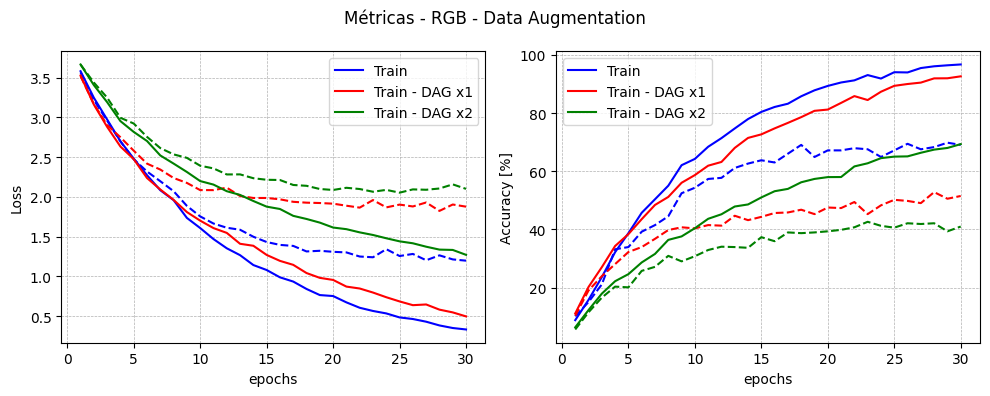

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot loss
for model, dag_loop, color in zip(models_rgb_dag, data_aug_loops, colors):
    epochs_vector = model.metrics['epochs']
    train_loss = model.metrics['loss']['train']
    val_loss = model.metrics['loss']['val']
    label = f"Train - DAG x{dag_loop}" if dag_loop > 0 else "Train"
    axs[0].plot(epochs_vector, train_loss, f"{color}-",label=label)
    axs[0].plot(epochs_vector, val_loss, f"{color}--")
axs[0].set_xlabel("epochs")
axs[0].set_ylabel("Loss")
axs[0].legend(loc='best')
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot accuracy
for model, dag_loop, color in zip(models_rgb_dag, data_aug_loops, colors):
    epochs_vector = model.metrics['epochs']
    train_acc = [100*acc for acc in model.metrics['accuracy']['train']]
    val_acc = [100*acc for acc in model.metrics['accuracy']['val']]
    label = f"Train - DAG x{dag_loop}" if dag_loop > 0 else "Train"
    axs[1].plot(epochs_vector, train_acc, f"{color}-",label=label)
    axs[1].plot(epochs_vector, val_acc, f"{color}--")
axs[1].set_xlabel("epochs")
axs[1].set_ylabel("Accuracy [%]")
axs[1].legend(loc='best')
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

plt.suptitle("Métricas - RGB - Data Augmentation")
plt.tight_layout()
filename = FIGURES_PATH + f"base/metrics_rgb_dag.png"
plt.savefig(filename, dpi=100, facecolor='w', edgecolor='w')
#plt.close()
plt.show()

# Resolución: Blanco y Negro & Data Augmentation

#### Definición de parámetros principales

In [4]:
params_bw_dag = {
        'conv_layers': [
            {
                'in_channels': 1,
                'out_channels': 16,
                'kernel_size': 3,
                'stride': 1,
                'padding': 1,
                'padding_mode': 'zeros',
                'pool_kernel_size': 2,
                'pool_stride': 2,
                'pool_padding': 0
            },
            {
                'in_channels': 16,
                'out_channels': 32,
                'kernel_size': 3,
                'stride': 1,
                'padding': 1,
                'padding_mode': 'zeros',
                'pool_kernel_size': 2,
                'pool_stride': 2,
                'pool_padding': 0
            },
            {
                'in_channels': 32,
                'out_channels': 64,
                'kernel_size': 3,
                'stride': 1,
                'padding': 1,
                'padding_mode': 'zeros',
                'pool_kernel_size': 2,
                'pool_stride': 2,
                'pool_padding': 0
            },
        ],
        'full_layers': [128],
        'n_classes': 53,
        'dropout_rate': 0.2,
        'activation': nn.ReLU(),
        'criterion': nn.CrossEntropyLoss(),
        'init_type': 'xavier',
        'device': device
    }

transform = transforms.Compose([transforms.ToTensor()])

In [5]:
colors = ['b', 'r', 'g']
batch_size = [128, 64, 64]
data_aug_loops = [0, 1, 2]
model_files = [f"bw_dag_{n}.pth" for n in data_aug_loops]
metric_files = [f"bw_dag_{n}.txt" for n in data_aug_loops]
datasets_bw_dag = []
models_bw_dag = []

In [6]:
# Define fit parameters.
optimizer = optim.AdamW
epochs = 10
lr = 1e-4
weight_decay = 1e-5
verbose = True
epoch_print = 1
tolerance = 1e-3
patience = 10

#### Creación los dataset y construcción de los modelos

In [7]:
for da_loop, model_file, metric_file in zip(
    data_aug_loops, model_files, metric_files):
    # Create the dataset
    cards = Cards(
        transform=transform,
        train_path=TRAIN_PATH, 
        valid_path=VALID_PATH, 
        test_path=TEST_PATH, 
        device=device
    )
    if da_loop > 0:
        cards.augmentDataset(loops=da_loop, join=True)
    cards.turnDataset2GrayScale()
    cards.getDatasets()
    cards.getDataloaders(batch_size=batch_size)
    datasets_bw_dag.append(cards)

    # Build the model
    conv_blocks = []
    for conv_layer in params_bw_dag['conv_layers']:
        conv_block = ConvolutionalBlock(**conv_layer)
        conv_blocks.append(conv_block)
    model = CNN(conv_blocks=conv_blocks, 
                image_shape=(cards.img_channels, cards.img_width, cards.img_height),
                n_classes=params_bw_dag['n_classes'],
                out_neurons=params_bw_dag['full_layers'][0],
                activation=params_bw_dag['activation'], 
                criterion=params_bw_dag['criterion'], 
                dropout_rate=params_bw_dag['dropout_rate'],
                init_type=params_bw_dag['init_type'],
                device=params_bw_dag['device'])
    model = model.to(model.device)

    # Load pre trained model if exists
    model_file = MODELS_PATH + f"base/{model_file}"
    metric_file = METRICS_PATH + f"base/{metric_file}"
    if os.path.exists(model_file) and os.path.exists(metric_file):
        model.load(model_file, metric_file)
    models_bw_dag.append(model)

#### Entrenamiento de los modelos

In [ ]:
for cards, model, model_file, metric_file in zip(
    datasets_bw_dag, models_bw_dag, model_files, metric_files):
    model.fit(train_dataloader=cards.train_dataloader, 
            optimizer=optimizer, 
            epochs=epochs, 
            lr=lr,
            regularization=weight_decay, 
            val_dataloader=cards.valid_dataloader, 
            verbose=verbose, 
            epoch_print=epoch_print, 
            tolerance=tolerance, 
            patience=patience)
    model_file = MODELS_PATH + f"base/{model_file}"
    metric_file = METRICS_PATH + f"base/{metric_file}"
    model.save(model_path=model_file, metrics_path=metric_file)
    print("-" * 60)

#### Gráfica de resultados

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot loss
for model, dag_loop, color in zip(models_bw_dag, data_aug_loops, colors):
    epochs_vector = model.metrics['epochs']
    train_loss = model.metrics['loss']['train']
    val_loss = model.metrics['loss']['val']
    label = f"Train - DAG x{dag_loop}" if dag_loop > 0 else "Train"
    axs[0].plot(epochs_vector, train_loss, f"{color}-",label=label)
    axs[0].plot(epochs_vector, val_loss, f"{color}--")
axs[0].set_xlabel("epochs")
axs[0].set_ylabel("Loss")
axs[0].legend(loc='best')
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot accuracy
for model, dag_loop, color in zip(models_bw_dag, data_aug_loops, colors):
    epochs_vector = model.metrics['epochs']
    train_acc = [100*acc for acc in model.metrics['accuracy']['train']]
    val_acc = [100*acc for acc in model.metrics['accuracy']['val']]
    label = f"Train - DAG x{dag_loop}" if dag_loop > 0 else "Train"
    axs[1].plot(epochs_vector, train_acc, f"{color}-",label=label)
    axs[1].plot(epochs_vector, val_acc, f"{color}--")
axs[1].set_xlabel("epochs")
axs[1].set_ylabel("Accuracy [%]")
axs[1].legend(loc='best')
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)

plt.suptitle("Métricas - B&W - Data Augmentation")
plt.tight_layout()
filename = FIGURES_PATH + f"base/metrics_bw_dag.png"
plt.savefig(filename, dpi=100, facecolor='w', edgecolor='w')
#plt.close()
plt.show()

## Encoder

In [ ]:
# Build encoder
encoder = Autoencoder(device=device)
encoder = encoder.to(encoder.device)

# Temporarily move autoencoder to CPU for the summary
encoder_cpu = encoder.to("cpu")
torchsummary.summary(encoder_cpu, (cards_aug.img_channels, cards_aug.img_width, cards_aug.img_height), device="cpu")
# Move the autoencoder back to MPS after summary (if MPS was available)
encoder = encoder.to(device)

In [47]:
# Define fit parameters for autoencoder.
optimizer = optim.Adam
epochs = 40
lr = 1e-4
verbose = True
epch_print = 5
tolerance = 1e-3
patience = 10

In [ ]:
# Train the autoencoder
encoder.fit(train_dataloader=cards_aug.train_dataloader, 
            optimizer=optimizer, 
            epochs=epochs, 
            lr=lr, 
            eval_dataloader=cards_aug.valid_dataloader, 
            verbose=verbose, 
            epch_print=epch_print, 
            tolerance=tolerance, 
            patience=patience)

# Save the autoencoder
model_path = MODELS_PATH + "autoencoder.pth"
metrics_path = METRICS_PATH + "autoencoder.txt"
encoder.save(model_path=model_path, metrics_path=metrics_path)

In [ ]:
for image, _ in cards_aug.train_data:
    image = image.unsqueeze(0)
    encoder.showEncodedImage(image)
    break

# Transfer Learning

In [16]:
from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.IMAGENET1K_V1
transforms = weights.transforms()

In [17]:
resnet18_model = resnet18(weights=weights)
resnet18_model = resnet18_model.to(device)

In [18]:
for param in resnet18_model.parameters():
    param.requires_grad = False

last_layer_in_features = resnet18_model.fc.in_features
resnet18_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=params_rgb_dag["n_classes"], device=device)

In [21]:
def computeLoss(model, dataloader):
        loss = 0.0
        samples = 0
        model.eval() # set the model to evaluation mode
        with torch.no_grad():   
            for inputs_batch, targets_batch in dataloader:
                batch_size = inputs_batch.size(0)
                samples += batch_size
                if device != 'cpu':
                    inputs_batch = inputs_batch.to(device)
                    targets_batch = targets_batch.to(device)
                predictions_batch = model(inputs_batch)
                loss += params_rgb_dag["criterion"](predictions_batch, targets_batch).item() * batch_size
        return loss / samples
    
def computeAccuracy(model, dataloader):
    correct, total = 0, 0
    model.eval() # set the model to evaluation mode
    with torch.no_grad():
        for inputs_batch, targets_batch in dataloader:
            if device != 'cpu':
                inputs_batch = inputs_batch.to(device)
                targets_batch = targets_batch.to(device)
            predictions_batch = model(inputs_batch)
            correct += (predictions_batch.argmax(dim=1) == targets_batch).sum().item()
            total += inputs_batch.size(0)
    return correct / total

In [24]:
def fit(model, train_dataloader, optimizer=optim.Adam, epochs=30, lr=1e-4, 
        regularization=0.0, val_dataloader=None, verbose=True, epoch_print=1):
    
        # Set the optimizer
        optimizer = optimizer(model.parameters(), lr=lr, weight_decay=regularization)

        # Start the training
        for i in range(epochs):
            model.train()
            for inputs_batch, targets_batch in train_dataloader:
                if device != 'cpu':
                    inputs_batch = inputs_batch.to(device)
                    targets_batch = targets_batch.to(device)
                predictions_batch = model(inputs_batch)
                loss_batch = params_rgb_dag["criterion"](predictions_batch, targets_batch)
                optimizer.zero_grad()
                loss_batch.backward()
                optimizer.step()

            # Evaluate the model
            model.eval()
            train_loss = computeLoss(model, train_dataloader)
            train_acc = computeAccuracy(model, train_dataloader)
            if val_dataloader:
                eval_loss = computeLoss(model, val_dataloader)
                eval_acc = computeAccuracy(model, val_dataloader)
            
            # Print the progress
            if verbose and (i + 1) % epoch_print == 0:
                eval_loss = eval_loss if val_dataloader else 'N/A'
                text = f"Epoch {i + 1}/{epochs}: "
                text += f"Loss ({train_loss:.4g}, {eval_loss:.4g}) \t "
                text += f"Accuracy ({100*train_acc:.2f}%, {100*eval_acc:.2f}%)"
                print(text)

In [ ]:
fit(resnet18_model, datasets_rgb_dag[0].train_dataloader, epochs=5, 
    lr=1e-3, val_dataloader=datasets_rgb_dag[0].valid_dataloader)